In [32]:
#BALL TRACKING WITH COLORS FOR ONE FRAME. Experimentation

In [2]:
# import the necessary packages
from collections import deque
from imutils.video import VideoStream
import numpy as np
import argparse
import cv2
import imutils
from skimage.morphology import erosion, dilation, opening, closing
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from PIL import Image
from IPython.display import Image as IPImage, display


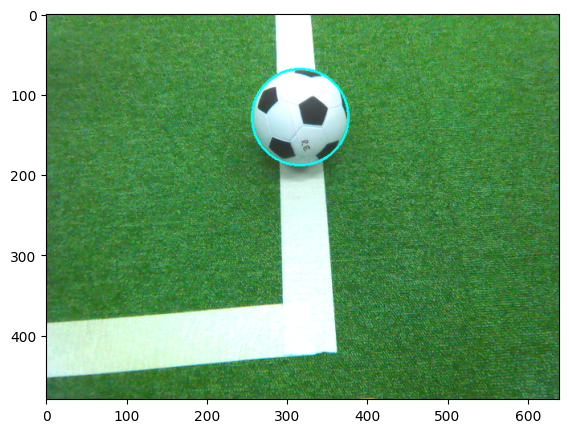

In [34]:

import struct
import imghdr


# https://stackoverflow.com/questions/8032642/how-to-obtain-image-size-using-standard-python-class-without-using-external-lib
def get_image_size(fname):
    '''Determine the image type of fhandle and return its size.
    from draco'''
    with open(fname, 'rb') as fhandle:
        head = fhandle.read(24)
        if len(head) != 24:
            return
        if imghdr.what(fname) == 'png':
            check = struct.unpack('>i', head[4:8])[0]
            if check != 0x0d0a1a0a:
                return
            width, height = struct.unpack('>ii', head[16:24])
        elif imghdr.what(fname) == 'gif':
            width, height = struct.unpack('<HH', head[6:10])
        elif imghdr.what(fname) == 'jpeg':
            try:
                fhandle.seek(0) # Read 0xff next
                size = 2
                ftype = 0
                while not 0xc0 <= ftype <= 0xcf:
                    fhandle.seek(size, 1)
                    byte = fhandle.read(1)
                    while ord(byte) == 0xff:
                        byte = fhandle.read(1)
                    ftype = ord(byte)
                    size = struct.unpack('>H', fhandle.read(2))[0] - 2
                # We are at a SOFn block
                fhandle.seek(1, 1)  # Skip `precision' byte.
                height, width = struct.unpack('>HH', fhandle.read(4))
            except Exception: #IGNORE:W0703
                return
        else:
            return
        return width, height
    

#0 0.49375 0.266666666667 0.1875 0.25

image_path = 'alfie_lm_ball_line0001.png' 
w, h = get_image_size(image_path)
pic_coord = cv2.imread(image_path)
cv2.circle(pic_coord, (int(0.49375*w), int(0.266666666667*h)), int(0.1875*w/2), (0, 255, 255), 2)

visualize(pic_coord)

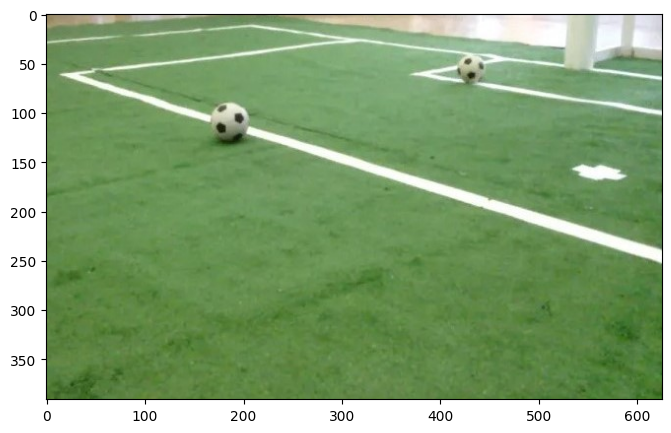

In [4]:
#NOT IN USE: define the lower and upper boundaries of the black, gray and white
#black_hsv = (0, 0, 0) #black
#white_hsv = (360, 0, 255) #white
#yellowish_hsv = (60, 30, 255)  # slightly yellowish


image_path = 'image_2_easy.jpg' 
frame = cv2.imread(image_path)


frame_copy =frame.copy()
frame_copy2 =frame.copy()



#Visualize function
def visualize(image, gray = False, hsv_rep = False):
    plt.figure(figsize=(10, 5))

    if hsv_rep and not gray:
        img = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
        plt.imshow(img) 

    elif not hsv_rep and gray:
        plt.imshow(image, cmap='gray')

    else:
        plt.imshow(image) 

    plt.show()

frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
visualize(frame)

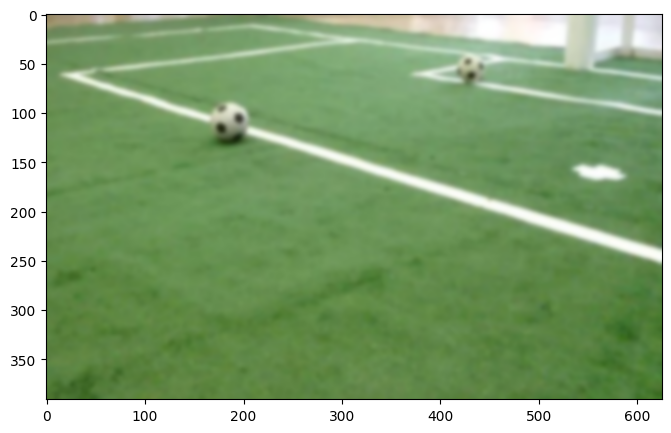

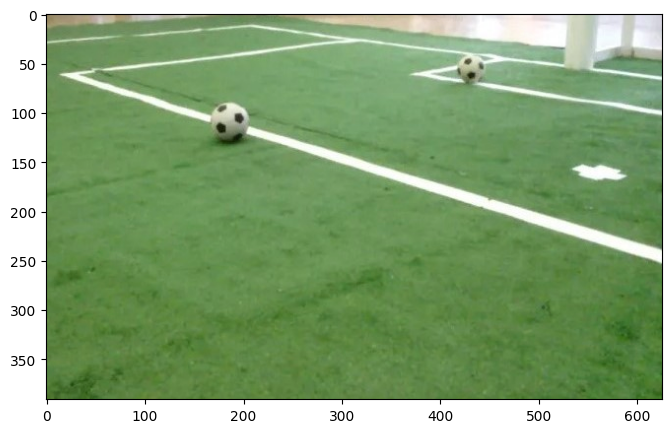

In [5]:
#frame = cv2.resize(frame, (600, 400))

#Blurred
blurred = cv2.GaussianBlur(frame, (11, 11), 0) #param
visualize(blurred)
#summed = cv2.add(blurred, 0, blurred) 
#new = cv2.multiply(summed, 1, summed)  
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
visualize(hsv, hsv_rep = True)

#Equalized
#hsv[:,:,2] = cv2.equalizeHist(hsv[:,:,2])
#equalized = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
#visualize(equalized)

#hsv_equalized = cv2.cvtColor(equalized, cv2.COLOR_BGR2HSV)
#visualize(hsv_equalized, hsv_rep = True)


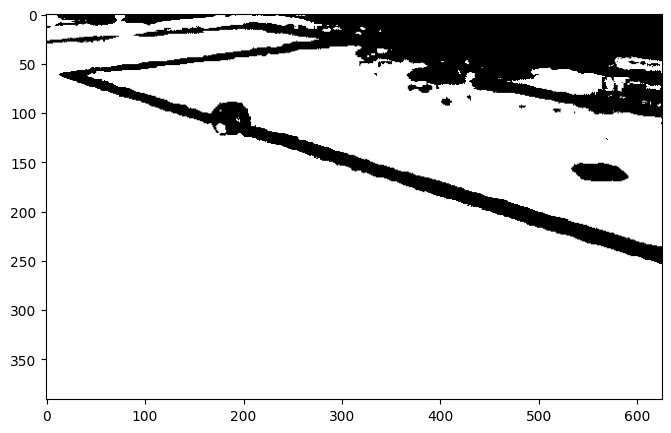

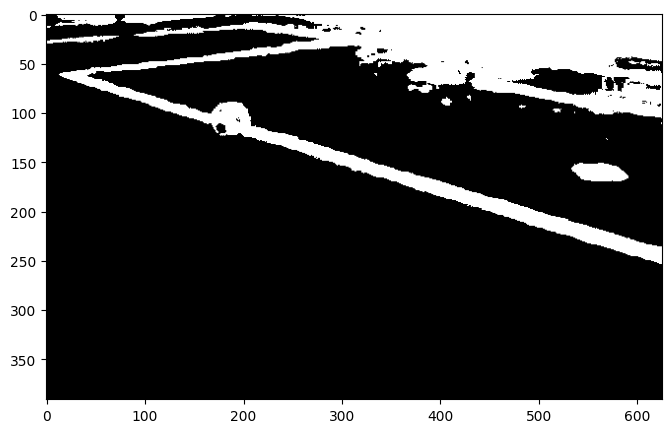

In [6]:
# To select black, white and gray values it chooses values with a low saturation
threshold_value = 70 #param
_, mask_inv = cv2.threshold(hsv[:, :, 1], threshold_value, 255, cv2.THRESH_BINARY)

visualize(mask_inv, gray=True)
mask =cv2.bitwise_not(mask_inv)
visualize(mask, gray=True)



#POSSIBLE TUNNING FOR THE FUTURE

    #yellowish_mask = cv2.inRange(hsv, (0, 0, 0), yellowish_hsv)

# Combine the masks to get the final mask
    #final_mask = cv2.bitwise_or(mask, yellowish_mask)


# An alternative i want to try:
def multi_erosion(img, selem, n):
    """Do a successive erosion on the same image by N times."""
    img = cv2.erode(img, selem, iterations=n)
    return img


def multi_dilation(img, selem, n):
    """Do a successive dilation on the same image by N times."""
    img = cv2.dilate(img, selem, iterations=n)
    return img

m = 1
m1 = 1
m2 = 1
m3 = 1
m4 = 1
selem_hor = np.array([[0, 0, 0],
                      [m, m, m],
                      [0, 0, 0]], dtype=np.uint8)

selem_ver = np.array([[0, m1, 0],
                      [0, m1, 0],
                      [0, m1, 0]], dtype=np.uint8)

selem_diag = np.array([[m3, 0, 0],
                      [0, m3, 0],
                      [0, 0, m3]], dtype=np.uint8)


selem_diag2 = np.array([[0, 0, m4],
                      [0, m4, 0],
                      [m4, 0, 0]], dtype=np.uint8)

selem_cir = np.array([[0, 0, m2, 0, 0],
                      [0, m2, m2, m2, 0],
                      [m2, m2, m2, m2, m2],
                      [0, m2, m2, m2, 0],
                      [0, 0, m2, 0, 0]], dtype=np.uint8)

# Morphological Operations
art1_new = multi_erosion(mask, selem_hor.astype(np.uint8), 5)
#art1_new = multi_dilation(art1_new, selem_cir.astype(np.uint8), 1)
art1_new = multi_erosion(art1_new, selem_ver.astype(np.uint8), 5)
art1_new = multi_erosion(art1_new, selem_diag.astype(np.uint8), 5)
art1_new = multi_erosion(art1_new, selem_diag2.astype(np.uint8), 5)
art1_new = multi_erosion(art1_new, selem_cir.astype(np.uint8), 1)
art1_new = multi_dilation(art1_new, selem_cir.astype(np.uint8), 2)
art1_new = np.where(art1_new != 0, 1, 0)

visualize(mask, gray=True)
visualize(art1_new, gray=True)



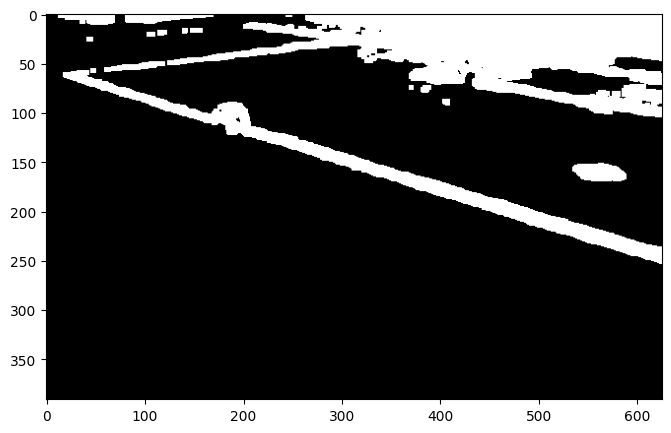

In [7]:
#This is what the dude did
mask1 = cv2.erode(mask, None, iterations=2) #param
mask2 = cv2.dilate(mask1, None, iterations=2) #param

visualize(mask2, gray = True)

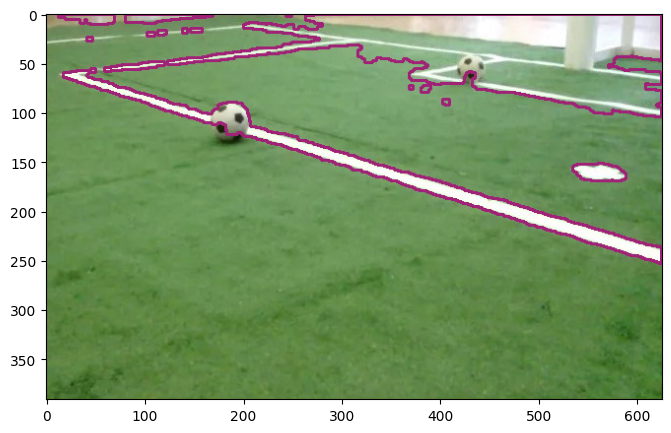

In [8]:
# find contours in the mask and initialize the current
# (x, y) center of the ball
mask = mask2
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
center = None

for c in cnts:
    cv2.drawContours(frame, [c], -1, (160, 34, 119), 2)

visualize(frame)

In [9]:
#Segmentation of contours to avoid problems when ball is over white lines

# Assuming you have a contour stored in the variable 'contour'
# You might need to adjust the parameters based on your specific case

def calculate_curvature(segment):
    # Fit a circle to the segment
    (x, y), radius = cv2.minEnclosingCircle(segment)
    print('radio:', radius)
    # Calculate curvature (reciprocal of the radius)
    if radius != 0:
        curvature = 1 / radius
    else:
        curvature = 0
    
    return curvature

def calculate_curvature2(points):
    # Reshape the points array to have two dimensions
    points = points.reshape(-1, 2)

    # Extract x and y coordinates of the points
    x = points[:, 0]
    y = points[:, 1]

    # Calculate the derivatives of x and y with respect to a parameter (e.g., arc length)
    dx_dt = np.gradient(x)
    dy_dt = np.gradient(y)

    # Calculate the second derivatives of x and y with respect to the parameter
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)

    # Calculate the curvature
    curvature = (dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / ((dx_dt**2 + dy_dt**2)**1.5)

    return curvature

def compute_circularity(contour):
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    circularity = 4 * np.pi * area / (perimeter * perimeter)
    return circularity


def calculate_curvature3(segment):
    # Get points
    length = len(segment)

    if length == 0:
        return 0.0
    
    x0, y0 = segment[0][0][0], segment[0][0][1]   #[num][0 always][o], o=0 is x and o=1 is
    xm, ym = segment[length//2][0][0], segment[length//2][0][1]
    xf, yf = segment[length-1][0][0], segment[length-1][0][1]

    # Get slopes
    slope0 = (ym-y0) / (xm-x0)    
    slope1 = (yf-ym) / (xf-xm)
    

    return slope1-slope0

len_segments = 40 #param
circular_limit = 0.35 #param

def divide_contour_into_segments(contour):
    # Calculate the total length of the contour
    total_length = cv2.arcLength(contour, closed=True)
    
    # Calculate the length of each segment depending on the contour circularity
    circularity = compute_circularity(contour)
    print('circularity', circularity)
    if abs(circularity - 1) < circular_limit:
        num_segments = 4
    else:
        num_segments = int(total_length/len_segments)

        
    segment_length = total_length / num_segments
    
    segments = []
    start_idx = 0

    # Divide the contour into segments
    for i in range(num_segments):
        #end_idx = int((i + 1) * len(contour) / num_segments)
        end_idx = int(i * len(contour) / num_segments + segment_length)
        segment = contour[start_idx:end_idx]
        segments.append(segment)
        start_idx = end_idx
    
    return segments



circles = []
for contour in cnts:
			#parameters to see how circular it is 
			area = cv2.contourArea(contour)
			perimeter = cv2.arcLength(contour, True)

			#parameters to make sure there is black inside the contour:
			threshold_black_value = 150
			_, mask_inv = cv2.threshold(frame[:, :, 2], threshold_black_value, 255, cv2.THRESH_BINARY_INV)


			# Check if there are dark gray pixels inside the filled contours

			if int(area) != 0  and ( np.any(frame[:, :, 2][contour[:, :, 1], contour[:, :, 0]] < threshold_black_value) ) and  10000> area> 1850: # Perimeter to avoid divide by 0, and area so it doesn't choose small circles
				circularity = 4 * np.pi * area / (perimeter * perimeter)
				circles.append((contour, circularity))
				cv2.drawContours(frame, [contour], -1, (87, 40, 30), 2)				  #cv2.drawContours can only be used for closed contours
				cv2.drawContours(frame_copy, [contour], -1, (87, 40, 30), 2)
				print(area)

				#Segmentation of contours
				segments = divide_contour_into_segments(contour, num_segments)
				old_index = 9999

				for i, segment in enumerate(segments):
				#for i in range(30, 35):
					#segment = segments[i]
					
					color = np.random.randint(0, 255, size=3)  # Generate a random color
					color = tuple(map(int, color))


					curvature = calculate_curvature3(segment)

					if abs(curvature) > 1:
						print('curvature:', curvature)
						cv2.polylines(frame, [segment], isClosed=False, thickness= 2, color=(70, 218, 40))

						if old_index == i-1:
							print("old:", old_segment)
							print("new:", segment)
							large_segment = np.concatenate((old_segment, segment ))							
							print("together:", large_segment)
							cv2.polylines(frame, [large_segment], isClosed=False, thickness= 2, color=(255, 0, 0))
							
						old_index = i
						old_segment = segment

					cv2.polylines(frame_copy, [segment], isClosed=False, thickness= 2, color=color)
					


# Choose the contour with the highest circularity
circles.sort(key=lambda x: abs(x[1] - 1))  # Sort by circularity closest to 1
best_circle = circles[0][0]  # Select the contour with closest circularity to 1
print("best", cv2.contourArea(best_circle))
# Draw the chosen contour
cv2.drawContours(frame, [best_circle], -1, (255, 0, 0), 2)
visualize(frame)
visualize(frame_copy)

perimeter 1429.9453008174896
circularity 0.050505322799803756
curvature: -1.1666666666666667
curvature: -1.1948717948717948
curvature: -2.5815217391304346
curvature: 1.1515151515151516
curvature: 1.2142857142857144
perimeter 1627.6295043230057
circularity 0.12367486147191215
curvature: 1.547008547008547
curvature: -10.0
curvature: -1.8484848484848486
curvature: 3.676470588235294
curvature: 3.0
curvature: -4.166666666666666
curvature: 1.5
curvature: -2.8333333333333335
curvature: -3.0
curvature: -23.625
best 105.0


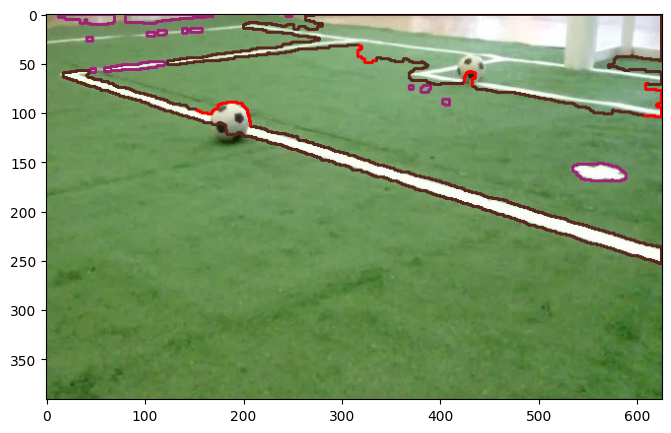

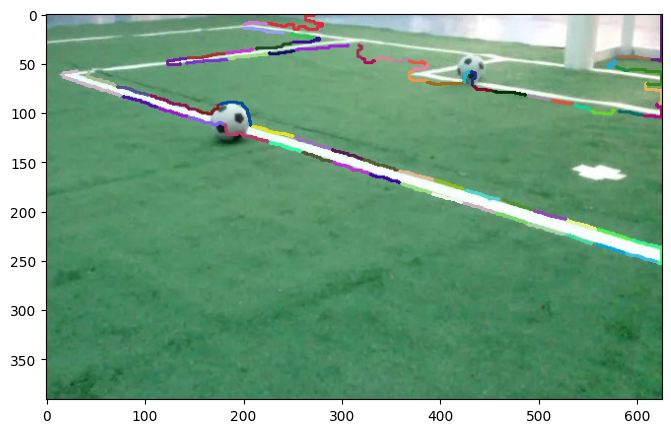

In [10]:
#NEW MODEL WORKING WITH SEGMENTATION AND EVERYTHING LALALA
areamax = 100000 #param
areamin = 785 #param
circles = []
for contour in cnts:
			#parameters to see how circular it is 
			area = cv2.contourArea(contour)
			perimeter = cv2.arcLength(contour, True)
			#parameters to make sure there is black inside the contour:
			threshold_black_value = 125 #param
			_, mask_inv = cv2.threshold(frame[:, :, 2], threshold_black_value, 255, cv2.THRESH_BINARY_INV)


			# Check if there are dark gray pixels inside the filled contours

			if int(area) != 0  and ( np.any(frame[:, :, 2][contour[:, :, 1], contour[:, :, 0]] < threshold_black_value) ) and  areamax > area> areamin: # Perimeter to avoid divide by 0, and area so it doesn't choose small circles
				circularity = 4 * np.pi * area / (perimeter * perimeter)
				cv2.drawContours(frame, [contour], -1, (87, 40, 30), 2)	  #cv2.drawContours can only be used for closed contours
				print("perimeter", perimeter)

				#Segmentation of contours
				segments = divide_contour_into_segments(contour)
				old_index = 9999

				cont = False

				for i, segment in enumerate(segments):
				#for i in range(30, 35):
					#segment = segments[i]
					
					color = np.random.randint(0, 255, size=3)  # Generate a random color
					color = tuple(map(int, color))


					curvature = calculate_curvature3(segment)

					if abs(curvature) > 1: #param
						print('curvature:', curvature)
						#cv2.polylines(frame, [segment], isClosed=False, thickness= 2, color=(70, 218, 40))

						if old_index == i-1: #Some of the segments of the large segment
							large_segment = np.concatenate((old_segment, segment ))
							cv2.polylines(frame, [large_segment], isClosed=False, thickness= 2, color=(255, 0, 0)) #red
							old_segment = large_segment
							cont = True #the large_segment still being increased

						else: #it is the first segment of a large_segment
							old_segment = segment
													
						old_index = i

					

					elif (old_index != i-1 and cont) or (i == len(segments)-1 and cont): #means that is the fisrt segment that is not in the large segment
							
							area = cv2.contourArea(large_segment)
							perimeter = cv2.arcLength(large_segment, True)
							circularity = 4 * np.pi * area / (perimeter * perimeter)
							circularity = compute_circularity(large_segment)
							circles.append((large_segment, circularity))							
							old_segment = segment
							cont = False
			
					cv2.polylines(frame_copy, [segment], isClosed=False, thickness= 2, color=color)
					


# Choose the contour with the highest circularity
circles.sort(key=lambda x: abs(x[1] - 1))  # Sort by circularity closest to 1
best_circle = circles[0][0]  # Select the contour with closest circularity to 1
print("best", cv2.contourArea(best_circle))

# Draw the chosen contour
#cv2.drawContours(frame, [best_circle], -1, (0, 0, 255), 2) #blue
visualize(frame)
visualize(frame_copy)

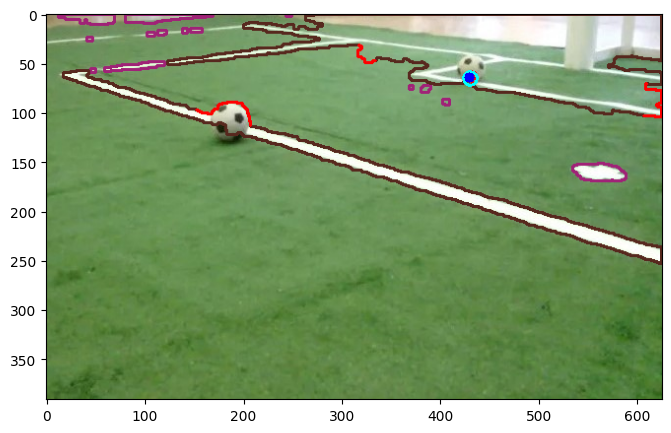

In [11]:
((x, y), radius) = cv2.minEnclosingCircle(best_circle)
M = cv2.moments(best_circle)
center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
# only proceed if the radius meets a minimum size. Usefull when there is a long segment too short
radius_limit = 0 #param

if radius > radius_limit:
    # draw the circle and centroid on the frame,
    # then update the list of tracked points
    cv2.circle(frame, (int(x), int(y)), int(radius),
        (0, 255, 255), 2)
    cv2.circle(frame, center, 5, (0, 0, 255), -1)

visualize(frame)